In [1]:
import gc
import os
import itertools
import pickle
import re
import time
from random import choice, choices
from functools import reduce
from tqdm import tqdm
from itertools import cycle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from functools import reduce
from itertools import cycle
from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn import metrics, model_selection, preprocessing, linear_model, ensemble, decomposition, tree
import lightgbm as lgb
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


import sys
sys.path.append('../../../')
from utils import *

## Prepro: change names to numbers

In [2]:
train_feats = pd.read_csv('../../../feature_eng/train_452feats.csv')
train_score = pd.read_csv('../../../data/train_scores.csv')

if 'score' not in train_feats.columns:
    train_feats = pd.merge(train_feats, train_score, on='id', how='left')

train_feats.replace([np.inf, -np.inf], np.nan, inplace=True)
cols = train_feats.columns

## Keep columns

In [3]:
# Options:
# "count_bursts", "word_sent_parag_agg", "pressed_keys", "paussed_features"
# "segments_visit", "paragraph_ratios", "time_gaps", "cursor_word_changes"
# "punctuation", "key_mouse", "time_feat"

endings_to_keep = ["-count_bursts", "-key_mouse", "-time_feat"]
endings_to_keep += ["id"]

dir_to_save_clf = "low_clf1"
dir_to_save_reg = "low_reg1"

cols_to_keep = [col for col in train_feats.columns if col.endswith(tuple(endings_to_keep)) or col in ['id', 'score']]

train_feats = train_feats[cols_to_keep]
print(len(train_feats.columns)-2)

150


In [4]:
counter = 0
new_columns = {}
for col in cols:
    if col != 'id' and col != 'score':
        new_columns[col] = counter
        counter += 1

train_feats.rename(columns=new_columns, inplace=True)

In [5]:
target_col = ['score']
drop_cols = ['id']
train_cols = [col for col in train_feats.columns if col not in target_col + drop_cols]

In [6]:
def objective(trial,train_x,train_y,val_x,val_y,RANDOM_STATE=41):

    params = {
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10.0, log=True),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.4,0.7,1.0]),
        'colsample_bynode': trial.suggest_categorical('colsample_bynode', [0.4,0.7,1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.7,1.0]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True), #trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [9,11,13,15,17,20]),
        'min_child_samples': trial.suggest_categorical('min_child_samples', [7,9,11,13,15,17,20]),
        'num_leaves': trial.suggest_int('num_leaves', 10, 38, step=4),
        'n_estimators': trial.suggest_int('n_estimators', 10, 190, step=20),
    }

    all_params = {
        "objective": "binary",
        "metric": "average_precision",
        'random_state': RANDOM_STATE,
        "verbosity": -1,
        "n_jobs": -1,
        **params
    }

    model = lgb.LGBMClassifier(**all_params)
    
    model.fit(train_x, train_y.values.ravel())#, eval_set=[(val_x, val_y)], #verbose=False,
    
    preds = model.predict_proba(val_x)[:,1]
    
    rmse = metrics.average_precision_score(val_y, preds)
    
    return rmse

In [7]:
score_thresh = 2

In [8]:
secondary_model_data = train_feats.copy()
secondary_model_data['score'] = (secondary_model_data['score']<=score_thresh).astype(int)

In [9]:
def lgb_calc_OOF(x_train, y_train, x_valid, y_valid, iter, split, RANDOM_STATE=42, save=False):
    # split into two validations
    x_valid1, x_valid2, y_valid1, y_valid2 = train_test_split(x_valid, y_valid, test_size=0.5, random_state=RANDOM_STATE, shuffle=False)

    '''Use v1, test on v2'''

    # Bayesian Opt using v1
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, x_train, y_train, x_valid1, y_valid1, RANDOM_STATE), n_trials=20)
    best_trial1 = study.best_trial.params

    # Get best params
    best_params = {
        "objective": "binary",
        "metric": "average_precision",
        'random_state': RANDOM_STATE,
        "verbosity": -1,
        "n_jobs": -1,
        **best_trial1
    }
        
    model = lgb.LGBMClassifier(**best_params)
    model.fit(x_train, y_train.values.ravel())
    if save:
        model.booster_.save_model(f'./{dir_to_save_reg}/lgb_iter{iter}_split{split}_val1.txt')

    # Predict on v2
    valid2_predict = model.predict_proba(x_valid2)[:,1]


    '''Use v2, test on v1'''

    # Bayesian Opt using v2
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, x_train, y_train, x_valid2, y_valid2,RANDOM_STATE), n_trials=20)
    best_trial2 = study.best_trial.params

    # Get best params
    best_params = {
        "objective": "binary",
        "metric": "average_precision",
        'random_state': RANDOM_STATE,
        "verbosity": -1,
        "n_jobs": -1,
        **best_trial2
    }
        
    model = lgb.LGBMClassifier(**best_params)
    model.fit(x_train, y_train.values.ravel())
    if save:
        model.booster_.save_model(f'./{dir_to_save_reg}/lgb_iter{iter}_split{split}_val2.txt')

    # Predict on v1
    valid1_predict = model.predict_proba(x_valid1)[:,1]

    # Return OOFs
    return np.concatenate([valid1_predict,valid2_predict])

In [10]:
OOF_CLF_PRED = np.zeros(len(secondary_model_data))

models_dict = {}

iterations = 5
n_splits = 4

for i in range(iterations):

    kf = model_selection.KFold(n_splits=n_splits, random_state=41 + i, shuffle=True)
    j = 0
    for fold, (train_idx, valid_idx) in enumerate(kf.split(secondary_model_data)):
        
        X_train, y_train = secondary_model_data.iloc[train_idx][train_cols], secondary_model_data.iloc[train_idx][target_col]
        X_valid, y_valid = secondary_model_data.iloc[valid_idx][train_cols], secondary_model_data.iloc[valid_idx][target_col]

        valid_predict = lgb_calc_OOF(X_train, y_train, X_valid, y_valid, i, j, RANDOM_STATE=41 + i, save=True)

        OOF_CLF_PRED[valid_idx] += valid_predict / iterations
        j+=1
        # models_dict[f'{fold}_{i}'] = model

[I 2023-12-27 23:33:00,527] A new study created in memory with name: no-name-3c2acc09-4199-4c8e-9c04-457fd1e974e2
[I 2023-12-27 23:33:00,672] Trial 0 finished with value: 0.4819216565528531 and parameters: {'reg_lambda': 0.00047498548109210103, 'reg_alpha': 0.17690289811332752, 'colsample_bytree': 0.4, 'colsample_bynode': 1.0, 'subsample': 1.0, 'learning_rate': 0.00022533605561717018, 'max_depth': 9, 'min_child_samples': 13, 'num_leaves': 34, 'n_estimators': 50}. Best is trial 0 with value: 0.4819216565528531.
[I 2023-12-27 23:33:00,709] Trial 1 finished with value: 0.48252384708805685 and parameters: {'reg_lambda': 0.0005834521612872837, 'reg_alpha': 0.029685005222958225, 'colsample_bytree': 0.7, 'colsample_bynode': 0.4, 'subsample': 1.0, 'learning_rate': 0.0001168989680370695, 'max_depth': 9, 'min_child_samples': 17, 'num_leaves': 10, 'n_estimators': 10}. Best is trial 1 with value: 0.48252384708805685.


[I 2023-12-27 23:33:01,139] Trial 2 finished with value: 0.5310795127710012 and parameters: {'reg_lambda': 0.00036729238640454613, 'reg_alpha': 0.42233141015240677, 'colsample_bytree': 1.0, 'colsample_bynode': 0.4, 'subsample': 1.0, 'learning_rate': 0.00011302861555809331, 'max_depth': 13, 'min_child_samples': 11, 'num_leaves': 26, 'n_estimators': 170}. Best is trial 2 with value: 0.5310795127710012.
[I 2023-12-27 23:33:01,182] Trial 3 finished with value: 0.5234622087986617 and parameters: {'reg_lambda': 0.06085161353817311, 'reg_alpha': 0.5631115536635775, 'colsample_bytree': 1.0, 'colsample_bynode': 0.7, 'subsample': 0.7, 'learning_rate': 1.6028150276070796e-05, 'max_depth': 13, 'min_child_samples': 7, 'num_leaves': 18, 'n_estimators': 10}. Best is trial 2 with value: 0.5310795127710012.
[I 2023-12-27 23:33:01,629] Trial 4 finished with value: 0.48612717028990055 and parameters: {'reg_lambda': 0.0028751023457032595, 'reg_alpha': 0.00043713161947006064, 'colsample_bytree': 0.4, 'cols

In [11]:
print('OOF AUC-PR LGBM = {:.5f}'.format(metrics.average_precision_score(secondary_model_data[target_col], 
                                                                   OOF_CLF_PRED)))

OOF AUC-PR LGBM = 0.37905


In [12]:
import pickle

with open(f'{dir_to_save_clf}/OOF_low_lgb.pkl', 'wb') as f:
    pickle.dump(OOF_CLF_PRED, f)

Text(0.5, 1.0, 'AUC-PR=0.3790506335495044')

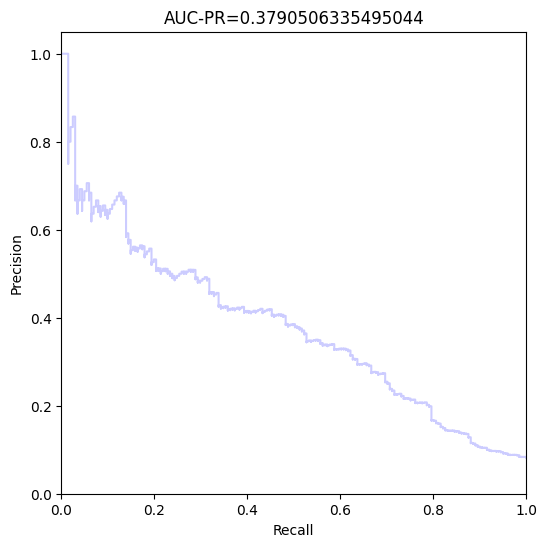

In [13]:
precision, recall, _ = metrics.precision_recall_curve(secondary_model_data[target_col], OOF_CLF_PRED)
average_precision = metrics.average_precision_score(secondary_model_data[target_col], OOF_CLF_PRED)

plt.figure(figsize=(6,6))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'AUC-PR={average_precision}')

In [14]:
fpr, tpr, thresholds = metrics.roc_curve(secondary_model_data[target_col], OOF_CLF_PRED)
roc_auc = metrics.auc(fpr, tpr)

best_argmax = np.argmax(np.sqrt(tpr*(1-fpr)))
best_thr = thresholds[best_argmax]
print('Best argmax: ', best_argmax)
print('Best threshold: ', best_thr)

Best argmax:  194
Best threshold:  0.08241203793626962


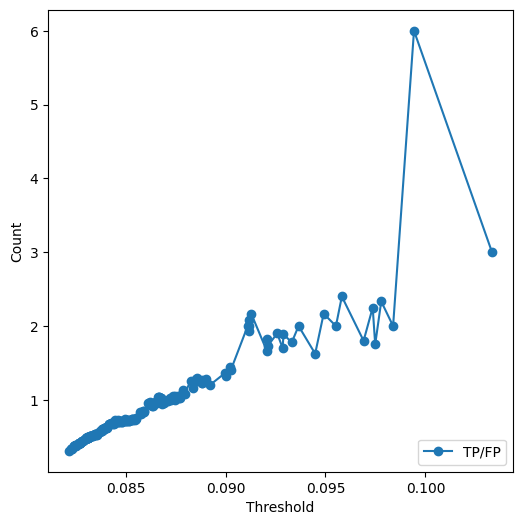

In [15]:
# Plot number of true positives and number of false positives as a function of the decision threshold for the first 50 thresholds, not fpr, but actual false positive count
tps = []
fps = []
ratios = []
max_ = 200

for thr in thresholds[3:max_]:
    _, fp, _, tp = metrics.confusion_matrix(secondary_model_data[target_col], OOF_CLF_PRED>=thr).ravel()
    ratios.append(tp/fp)
    tps.append(tp)
    fps.append(fp)

plt.figure(figsize=(6,6))
plt.plot(thresholds[3:max_], ratios, label='TP/FP', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Count')
plt.legend(loc="lower right")

In [16]:
print(fps[10])
print(tps[10])

8
13


## Low Regressor

In [17]:
secondary_model_data = train_feats[train_feats['score']<=score_thresh].copy()

In [18]:
def objective(trial,train_x,train_y,val_x,val_y,RANDOM_STATE=41):

    params = {
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 10.0, log=True),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.4,0.7,1.0]),
        'colsample_bynode': trial.suggest_categorical('colsample_bynode', [0.4,0.7,1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.7,1.0]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True), #trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [5,9,11]),
        'min_child_samples': trial.suggest_categorical('min_child_samples', [5,7,9,11]),
        'num_leaves': trial.suggest_int('num_leaves', 8, 20, step=4),
        'n_estimators': trial.suggest_int('n_estimators', 5, 55, step=10),
    }

    all_params = {
        "objective": "rmse",
        "metric": "rmse",
        'random_state': RANDOM_STATE,
        "verbosity": -1,
        "n_jobs": -1,
        **params
    }

    model = lgb.LGBMRegressor(**all_params)
    
    model.fit(train_x, train_y)#, eval_set=[(val_x, val_y)], #verbose=False,
    
    preds = model.predict(val_x)
    
    rmse = mean_squared_error(val_y, preds, squared=False)
    
    return rmse

In [19]:
def lgb_calc_OOF(x_train, y_train, x_valid, y_valid, iter, split, RANDOM_STATE=42, save=False):
    # split into two validations
    x_valid1, x_valid2, y_valid1, y_valid2 = train_test_split(x_valid, y_valid, test_size=0.5, random_state=RANDOM_STATE, shuffle=False)

    '''Use v1, test on v2'''

    # Bayesian Opt using v1
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, x_train, y_train, x_valid1, y_valid1,RANDOM_STATE), n_trials=20)
    best_trial1 = study.best_trial.params

    # Get best params
    best_params = {
        "objective": "rmse",
        "metric": "rmse",
        'random_state': RANDOM_STATE,
        "verbosity": -1,
        "n_jobs": -1,
        **best_trial1
    }
        
    model = lgb.LGBMRegressor(**best_params)
    model.fit(x_train, y_train)
    if save:
        model.booster_.save_model(f'./{dir_to_save_reg}/lgb_iter{iter}_split{split}_val1.txt')

    # Predict on v2
    valid2_predict = model.predict(x_valid2)


    '''Use v2, test on v1'''

    # Bayesian Opt using v2
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, x_train, y_train, x_valid2, y_valid2,RANDOM_STATE), n_trials=20)
    best_trial2 = study.best_trial.params

    # Get best params
    best_params = {
        "objective": "rmse",
        "metric": "rmse",
        'random_state': RANDOM_STATE,
        "verbosity": -1,
        "n_jobs": -1,
        **best_trial2
    }

    model = lgb.LGBMRegressor(**best_params)
    model.fit(x_train, y_train)
    if save:
        model.booster_.save_model(f'./{dir_to_save_reg}/lgb_iter{iter}_split{split}_val2.txt')

    # Predict on v1
    valid1_predict = model.predict(x_valid1)

    # Return OOFs
    return np.concatenate([valid1_predict,valid2_predict])

In [20]:
OOF_LOW_SCORE = np.zeros(len(secondary_model_data))

models_dict = {}

iterations = 5
n_splits = 4

for i in range(iterations):

    kf = model_selection.KFold(n_splits=n_splits, random_state=41 + i, shuffle=True)
    j = 0
    for fold, (train_idx, valid_idx) in enumerate(kf.split(secondary_model_data)):
        
        X_train, y_train = secondary_model_data.iloc[train_idx][train_cols], secondary_model_data.iloc[train_idx][target_col]
        X_valid, y_valid = secondary_model_data.iloc[valid_idx][train_cols], secondary_model_data.iloc[valid_idx][target_col]

        valid_predict = lgb_calc_OOF(X_train, y_train, X_valid, y_valid, i, j, RANDOM_STATE=41 + i, save=True)

        OOF_LOW_SCORE[valid_idx] += valid_predict / iterations
        j+=1

[I 2023-12-27 23:36:11,645] A new study created in memory with name: no-name-a9a2e206-31c1-409b-9089-59e0b4add448
[I 2023-12-27 23:36:11,689] Trial 0 finished with value: 0.5426478134755325 and parameters: {'reg_lambda': 0.007431615665322621, 'reg_alpha': 3.4068573046246936e-05, 'colsample_bytree': 0.7, 'colsample_bynode': 0.7, 'subsample': 0.7, 'learning_rate': 0.0009958636084172348, 'max_depth': 5, 'min_child_samples': 5, 'num_leaves': 12, 'n_estimators': 45}. Best is trial 0 with value: 0.5426478134755325.
[I 2023-12-27 23:36:11,702] Trial 1 finished with value: 0.5414217226748749 and parameters: {'reg_lambda': 1.6324457622378699, 'reg_alpha': 0.004020142910922101, 'colsample_bytree': 0.4, 'colsample_bynode': 0.4, 'subsample': 0.4, 'learning_rate': 0.0001777894722603573, 'max_depth': 5, 'min_child_samples': 9, 'num_leaves': 12, 'n_estimators': 5}. Best is trial 1 with value: 0.5414217226748749.
[I 2023-12-27 23:36:11,740] Trial 2 finished with value: 0.5414942311326867 and parameter

In [21]:
print('OOF metric LGBM = {:.5f}'.format(metrics.mean_squared_error(secondary_model_data[target_col], 
                                                                   OOF_LOW_SCORE,
                                                                   squared=False)))

OOF metric LGBM = 0.41464


In [22]:
secondary_model_data['low score'] = OOF_LOW_SCORE

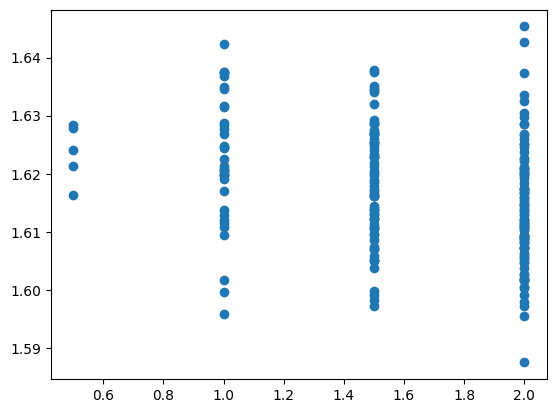

In [23]:
plt.plot(secondary_model_data['score'], secondary_model_data['low score'], 'o')

In [24]:
sys.exit()

SystemExit: 

C:\Users\luis.pinto1\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py:3441: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
with open('../regressors_for_192feats_corr/base_lgb/OOF_base_lgb.pkl', 'rb') as f:
    OOF_REG = pickle.load(f)

In [ ]:
train_scores = pd.read_csv('../../../data/train_scores.csv')
train_scores['lgb score'] = OOF_REG
train_scores['clf pred'] = OOF_CLF_PRED>thresholds[10]

In [ ]:
train_scores = train_scores.merge(secondary_model_data[['id', 'low score']], on='id', how='left')

In [ ]:
print('OOF metric LGBM = {:.5f}'.format(metrics.mean_squared_error(train_scores[target_col],
                                                                   train_scores['lgb score'],
                                                                   squared=False)))

In [ ]:
x_temp = train_scores[train_scores['clf pred']==1]

print('OOF metric LGBM = {:.5f}'.format(metrics.mean_squared_error(x_temp[target_col],
                                                                   x_temp['lgb score'],
                                                                   squared=False)))

In [ ]:
x_temp = train_scores[train_scores['clf pred']==1].fillna(1.4)

print('OOF metric LGBM after replacement = {:.5f}'.format(metrics.mean_squared_error(x_temp[target_col], 
                                                                   x_temp['low score'],
                                                                   squared=False)))